The aim is to make the following experiments:

* train and test a support vector machine classifier through cross-validation;
* study the effect of the parameter gamma of this classifier using a
  validation curve;
* use a learning curve to determine the usefulness of adding new samples in the dataset when building a classifier.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('transfusion.csv')
df.sample(5)

,Recency,Frequency,Monetary,Time,target
505,2,41,10250,98,1
260,4,4,1000,41,0
296,14,5,1250,28,0
396,21,2,500,21,1
84,2,6,1500,28,1


In [3]:
df.shape

(748, 5)

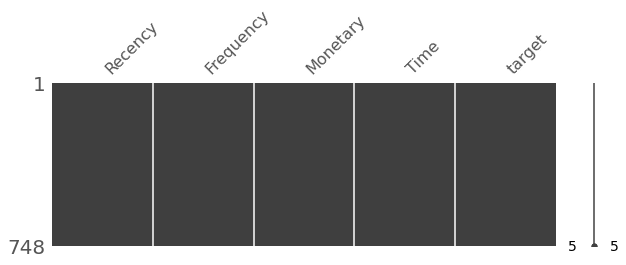

In [4]:
msno.matrix(df, figsize=(10, 3))

In [5]:
data, target = df.drop(columns=['target']), df['target']

In [6]:
target.value_counts()

0    570
1    178
Name: target, dtype: int64

We will use a support vector machine classifier (SVM). In its most simple
form, a SVM classifier is a linear classifier behaving similarly to a logistic regression. Indeed, the optimization used to find the optimal weights of the linear model are different. Also, this classifier can become more flexible/expressive by using a so-called kernel that makes the model become non-linear.

We will use an RBF kernel where a parameter `gamma` allows to tune the
flexibility of the model.

First let's create a predictive pipeline made of:

* a [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
  with default parameter;
* a [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
  where the parameter `kernel` could be set to `"rbf"`. Note that this is the default.

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

Evaluate the generalization performance of your model by cross-validation with
a `ShuffleSplit` scheme. Thus, you can use
[`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
and pass a
[`sklearn.model_selection.ShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)
to the `cv` parameter. Only fix the `random_state=0` in the `ShuffleSplit` and
let the other parameters to the default.


In [8]:
from sklearn.model_selection import ShuffleSplit, cross_validate

cv = ShuffleSplit(n_splits=30, test_size=.33, random_state=0)
cv_results = cross_validate(
    model,
    data,
    target,
    cv=cv,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
)

In [9]:
cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score,train_score
0,0.022598,0.011626,0.732794,0.790419
1,0.021998,0.009116,0.757085,0.782435
2,0.018048,0.009975,0.785425,0.788423
3,0.019846,0.009160,0.765182,0.800399
4,0.028325,0.008884,0.753036,0.808383


As previously mentioned, the parameter `gamma` is one of the parameters
controlling under/over-fitting in support vector machine with an RBF kernel.

Evaluate the effect of the parameter `gamma` by using the
[`sklearn.model_selection.validation_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html)
function. You can leave the default `scoring=None` which is equivalent to
`scoring="accuracy"` for classification problems. You can vary `gamma` between
`10e-3` and `10e2` by generating samples on a logarithmic scale with the help
of `np.logspace(-3, 2, num=30)`.

Since we are manipulating a `Pipeline` the parameter name will be set to
`svc__gamma` instead of only `gamma`. You can retrieve the parameter name
using `model.get_params().keys()`. We will go more into detail regarding
accessing and setting hyperparameter in the next section.

In [10]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [11]:
from sklearn.model_selection import validation_curve

gamma_range= np.logspace(-3, 2, num=30)

train_error, test_error = validation_curve(
    model,
    data,
    target,
    cv=cv,
    scoring='accuracy',
    param_name='svc__gamma',
    param_range= gamma_range,
    n_jobs=-1
)

Plot the validation curve for the train and test scores.

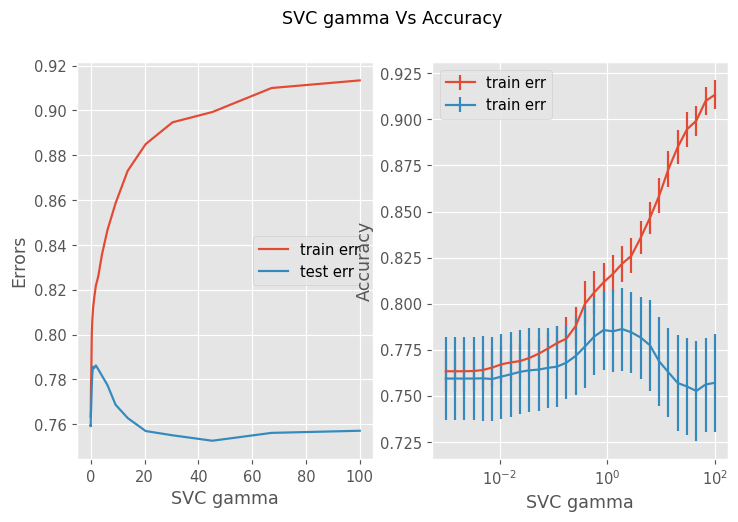

In [15]:
plt.figure(figsize=(8, 5), dpi=105)

plt.subplot(1,2,1)
plt.plot(gamma_range, train_error.mean(axis=1), label='train err')
plt.plot(gamma_range, test_error.mean(axis=1), label='test err')
plt.xlabel('SVC gamma')
plt.ylabel('Errors')
plt.legend()

plt.subplot(1,2,2)
plt.errorbar(
    gamma_range,
    train_error.mean(axis=1),
    yerr=train_error.std(axis=1),
    label='train err' 
)
plt.errorbar(
    gamma_range,
    test_error.mean(axis=1),
    yerr=test_error.std(axis=1),
    label='train err' 
)
plt.xscale('log')
plt.xlabel('SVC gamma')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle('SVC gamma Vs Accuracy')
plt.show();

Looking at the curve, we can clearly identify the over-fitting regime of the SVC classifier when gamma > 1. The best setting is around gamma = 1 while for gamma < 1, it is not very clear if the classifier is under-fitting but the testing score is worse than for gamma = 1.

Now, you can perform an analysis to check whether adding new samples to the
dataset could help our model to better generalize. Compute the learning curve
(using [`sklearn.model_selection.learning_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html))
by computing the train and test scores for different training dataset size.
Plot the train and test scores with respect to the number of samples.

In [13]:
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(.1, 1., num=5, endpoint=True)

results = learning_curve(
    model,
    data,
    target,
    cv=cv,
    scoring='accuracy',
    train_sizes=train_sizes,
    n_jobs=-1
)

train_size, train_err, test_err = results[:3]

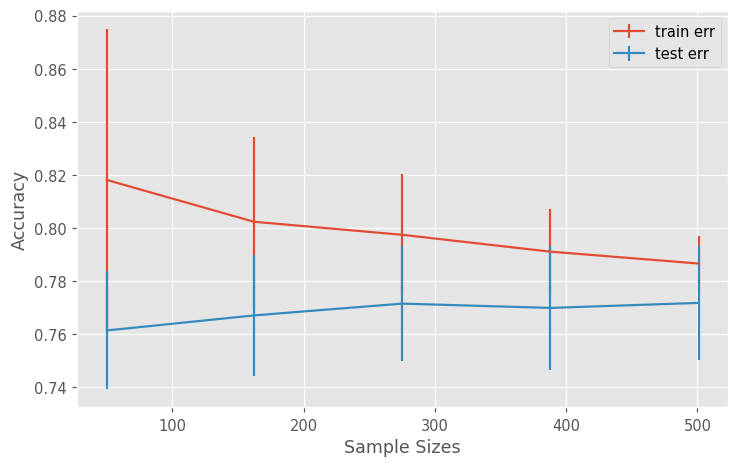

In [17]:
plt.figure(figsize=(8, 5), dpi=105)
plt.errorbar(
    train_size, 
    train_err.mean(axis=1),
    yerr=train_err.std(axis=1),
    label='train err'
)
plt.errorbar(
    train_size, 
    test_err.mean(axis=1),
    yerr=test_err.std(axis=1),
    label='test err'
)


plt.xlabel('Sample Sizes')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

We observe that adding new samples to the training dataset does not seem to improve the training and testing scores. In particular, the testing score oscillates around 76% accuracy. Indeed, ~76% of the samples belong to the class "not donated". Notice then that a classifier that always predicts the "not donated" class would achieve an accuracy of 76% without using any information from the data itself. This can mean that our small pipeline is not able to use the input features to improve upon that simplistic baseline, and increasing the training set size does not help either.

It could be the case that the input features are fundamentally not very informative and the classification problem is fundamentally impossible to solve to a high accuracy. But it could also be the case that our choice of using the default hyperparameter value of the SVC class was a bad idea, or that the choice of the SVC class is itself sub-optimal.